NOTE: Make sure to run the script pickle_wildfire_data.py to pickle the data. The pickled numpy arrays will be used by the Dataset objects to load in the actual data.

In [1]:
import random
import torch
from torch.utils.data import Dataset, IterableDataset, DataLoader
import pickle
import numpy as np
import torchvision
from typing import Tuple

# The PyTorch Datasets

In [2]:
def unpickle(f):
    with open(f, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def new_random_crop(labels, new_crop_size):
    crop_map = create_crop_map(len(labels), new_crop_size)
    good_indices = find_good_samples(labels, crop_map, new_crop_size)
    return crop_map, good_indices


def create_crop_map(data_size, crop_size):
    # The crop map assigns an x_shift and y_shift to each sample in the main 64 x 64 dataset.
    crop_map = []
    for i in range(data_size):
        # random.randint returns beginning <= n <= end, hence the minus 1.
        x_shift = random.randint(0, 64 - crop_size - 1)
        y_shift = random.randint(0, 64 - crop_size - 1)
        crop_map.append((x_shift, y_shift))
    return np.array(crop_map)


def get_cropped_sample(index, crop_map, crop_size, data, labels):
    x_shift, y_shift = crop_map[index]
    cropped_features = data[index, :, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size]
    cropped_label = labels[index, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size]
        
    return cropped_features, cropped_label


def find_good_samples(labels, crop_map, crop_size):
    # Finds the indices of samples that have no missing data in their labels.
    # This is determined AFTER generating a crop map and applying the crop to the original 64 x 64 label.
    good_indices = []
    for i in range(len(labels)):
        x_shift, y_shift = crop_map[i]
        if np.all(np.invert(labels[i, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size] == -1)):
            good_indices.append(i)
    return np.array(good_indices)


class WildfireDataset(torch.utils.data.Dataset):
    def __init__(self, data_filename, labels_filename):
        self.data, self.labels = unpickle(data_filename), unpickle(labels_filename)
        self.crop_size = 32
        self.crop_map, self.good_indices = new_random_crop(self.labels, self.crop_size)
        
        print(f"data size: {self.data.nbytes}")
        print(f"label size: {self.labels.nbytes}")
        print(f"crop_map size: {self.crop_map.nbytes}")
        print(f"good_indices size: {self.good_indices.nbytes}")
        print(f"total size: {self.data.nbytes + self.labels.nbytes + self.crop_map.nbytes + self.good_indices.nbytes}")
        print("finished initializing")
        
    def __len__(self):
        return len(self.good_indices)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        index = self.good_indices[index]
        
        cropped_features, cropped_label = get_cropped_sample(index, self.crop_map, self.crop_size, self.data, self.labels)

        sample = (torch.from_numpy(cropped_features), torch.from_numpy(np.expand_dims(cropped_label, axis=0)))

        return sample


class OversampledWildfireDataset(torch.utils.data.Dataset):
    def __init__(self, data_filename, labels_filename, transform=None):
        self.data, self.labels = unpickle(data_filename), unpickle(labels_filename)
        self.crop_size = 32
        self.crop_map, self.good_indices = new_random_crop(self.labels, self.crop_size)
        
        self.oversample_indices = self._find_samples_for_oversampling()
        
        print(f"data size: {self.data.nbytes}")
        print(f"label size: {self.labels.nbytes}")
        print(f"crop_map size: {self.crop_map.nbytes}")
        print(f"good_indices size: {self.good_indices.nbytes}")
        print(f"total size: {self.data.nbytes + self.labels.nbytes + self.crop_map.nbytes + self.good_indices.nbytes}")
        print("finished initializing")

    def __len__(self):
        return len(self.good_indices) * 2

    def __getitem__(self, index):
        
        index = self.good_indices[index] if index < len(self.good_indices) // 2 else self._get_random_oversample_index()
            
        cropped_features, cropped_label = get_cropped_sample(index, self.crop_map, self.crop_size, self.data, self.labels)

        sample = (torch.from_numpy(cropped_features), torch.from_numpy(np.expand_dims(cropped_label, axis=0)))
        
        return sample
    
    def _find_samples_for_oversampling(self):
        oversample_indices = []
        
        #print(len(self.good_indices))
        for i in range(len(self.good_indices)):
            index = self.good_indices[i]
            x_shift, y_shift = self.crop_map[index]
            cropped_label = self.labels[index, x_shift : x_shift + self.crop_size, y_shift : y_shift + self.crop_size]
            unique_target, counts_target = np.unique(cropped_label, return_counts=True)
            target_counts_map = {int(unique_target[j]): int(counts_target[j]) for j in range(len(unique_target))}
            
            for key, value in target_counts_map.items():
                if key == 1 and (value/1024) >= 0.15: # adjust the fraction to see which masks have a lot of fire
                    oversample_indices.append(index)
        #print(len(oversample_indices))
        #print(oversample_indices)
        return oversample_indices
        
    
    def _get_random_oversample_index(self):
        return random.choice(self.oversample_indices)

In [3]:
TEST_DATA_FILENAME = './data/next-day-wildfire-spread/test.data'
TEST_LABELS_FILENAME = './data/next-day-wildfire-spread/test.labels'

test_dataset = WildfireDataset(TEST_DATA_FILENAME, TEST_LABELS_FILENAME)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

print(len(test_loader))
print(len(test_dataset))

data size: 332070912
label size: 27672576
crop_map size: 27024
good_indices size: 10960
total size: 359781472
finished initializing
14
1370


In [4]:
batch = next(iter(test_loader))
images, labels = batch

original_test_data = unpickle(TEST_DATA_FILENAME)
original_test_labels = unpickle(TEST_LABELS_FILENAME)
original_test_labels = np.expand_dims(original_test_labels, axis=1)

print(original_test_data.shape)
print(original_test_labels.shape)

(1689, 12, 64, 64)
(1689, 1, 64, 64)


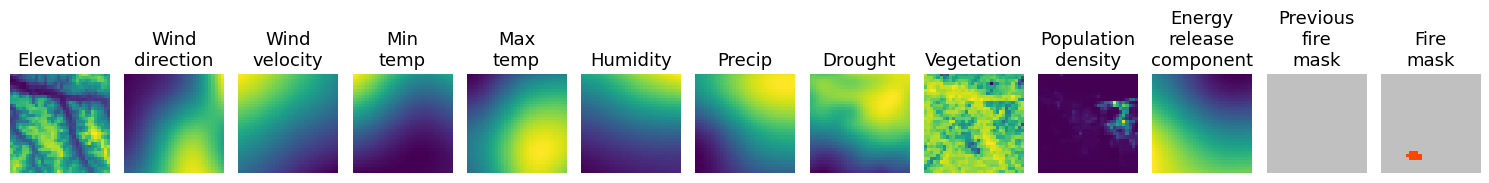

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors

TITLES = [
    'Elevation',
    'Wind\ndirection',
    'Wind\nvelocity',
    'Min\ntemp',
    'Max\ntemp',
    'Humidity',
    'Precip',
    'Drought',
    'Vegetation',
    'Population\ndensity',
    'Energy\nrelease\ncomponent',
    'Previous\nfire\nmask',
    'Fire\nmask',
    'Predicted\nfire\nmask'
]

CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.1, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

def imshow(sample):
    fig = plt.figure(figsize=(15,6.5))
    for i in range(13):
        plt.subplot(1, 13, i + 1)
        plt.title(TITLES[i], fontsize=13)
        if i < 12 - 1:
            plt.imshow(sample[0][i, :, :], cmap='viridis')
        if i == 12 - 1:
            plt.imshow(sample[0][-1, :, :], cmap=CMAP, norm=NORM)
        if i == 12:
            plt.imshow(sample[1][0, :, :], cmap=CMAP, norm=NORM)
        plt.axis('off')
    plt.tight_layout()

imshow((images[0], labels[0]))

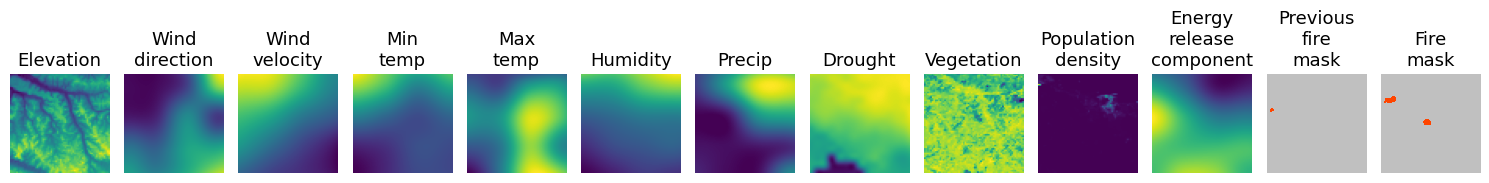

In [6]:
imshow((original_test_data[0], original_test_labels[0]))

# The Neural Networks

In [7]:
# Neural networks that can be used on the dataset
# Make sure the training data is scrubbed of any target fire masks that have missing data

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.linear(x))
        x = x.reshape(-1, 1, 32, 32)
        return x

class BinaryClassifierCNN(torch.nn.Module):
    def __init__(self, image_size):
        flattened_conv2_output_dimensions = (image_size//4)**2
        super(BinaryClassifierCNN, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(12, 16, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.out = torch.nn.Sequential(
            torch.nn.Linear(32 * flattened_conv2_output_dimensions, 1024), # 1024 pixels, output represents probability of fire.
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        x = x.reshape(-1, 1, 32, 32)
        return x
    

# Tutorial for the autoencoder: https://www.youtube.com/watch?v=345wRyqKkQ0
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    
    def forward(self, x):
        return x.view(self.shape)
    
class Trim(torch.nn.Module):
    def __init__(self, *args):
        super(Trim, self).__init__()
    
    def forward(self, x):
        return x[:, :, :32, :32]

class ConvolutionalAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(12, 16, 3, 1, 0), # 32 x 32 -> 30 x 30
            torch.nn.LeakyReLU(0.01),
            torch.nn.Dropout(0.1),
            torch.nn.Conv2d(16, 32, 3, 2, 0), # 30 x 30 -> 14 x 14
            torch.nn.LeakyReLU(0.01),
            torch.nn.Dropout(0.1),
            torch.nn.Conv2d(32, 32, 3, 2, 0), # 14 x 14 -> 6 x 6
            torch.nn.Flatten(),
            torch.nn.Linear(1152, 2) # 1152 = 32 * 6  * 6
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 1152),
            Reshape(-1, 32, 6, 6),
            torch.nn.ConvTranspose2d(32, 32, 3, 1, 0), # 6 x 6 -> 8 x 8
            torch.nn.LeakyReLU(0.01),
            torch.nn.ConvTranspose2d(32, 16, 3, 2, 1), # 8 x 8 -> 15 x 15
            torch.nn.LeakyReLU(0.01),
            torch.nn.ConvTranspose2d(16, 16, 3, 2, 0), # 15 x 15 -> 31 x 31
            torch.nn.LeakyReLU(0.01),
            torch.nn.ConvTranspose2d(16, 1, 3, 1, 0), # 31 x 31 -> 33 x 33
            Trim(),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Loading in the model

In [24]:
MODEL_PATH = "./savedModels/model-ConvolutionalAutoencoder-bestLoss-Rank-1.weights"
model = ConvolutionalAutoencoder()

#https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/2
# original saved file with DataParallel
state_dict = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)

model.eval()

ConvolutionalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=1152, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=1152, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0.01)
    (8): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1,

# Testing the loaded in model

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

def test_model(test_loader, model):   
    total = 0
    correct = 0
    incorrect = 0
    
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        
        for i, (batch_inputs, batch_labels) in enumerate(test_loader):
            out = model(batch_inputs)
            
            targets = torch.flatten(batch_labels).type(torch.FloatTensor).numpy()
            out = torch.flatten(out).numpy()
            
            fire_predictions = np.rint(out)
            
            y_pred.extend(fire_predictions)
            y_true.extend(targets)
            
            correct += np.sum(fire_predictions == targets)
            incorrect += np.sum(fire_predictions != targets)
            
            total += len(targets)
    
    accuracy = 100 * correct/total
    print(f"Total = {total}")
    print(f"This should match the total: {correct + incorrect}")
    print(f"Total correct = {correct}")
    print(f"Total incorrect = {incorrect}")
    print(f"Overall accuracy: {accuracy}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print("\nPrecision, Recall, Fscore, Support:")
    print(np.vstack(precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])))

In [26]:
test_model(test_loader, model)

Total = 1402880
This should match the total: 1402880
Total correct = 1361774
Total incorrect = 41106
Overall accuracy: 97.06988480839416

Confusion Matrix:
[[1361752     100]
 [  41006      22]]

Precision, Recall, Fscore, Support:
[[9.70767588e-01 1.80327869e-01]
 [9.99926571e-01 5.36219167e-04]
 [9.85131357e-01 1.06925881e-03]
 [1.36185200e+06 4.10280000e+04]]


# Plotting the loaded in model

In [27]:
TITLES = [
    'Elevation',
    'Wind\ndirection',
    'Wind\nvelocity',
    'Min\ntemp',
    'Max\ntemp',
    'Humidity',
    'Precip',
    'Drought',
    'Vegetation',
    'Population\ndensity',
    'Energy\nrelease\ncomponent',
    'Previous\nfire\nmask',
    'Fire\nmask',
    'Predicted\nfire\nmask'
]

def plot_5_predictions(loader, model, offset):
    with torch.no_grad():
        batch = next(iter(loader))
        out = model(batch[0])
        out = out.reshape(out.size(0), 32, 32).numpy()
        fire_predictions = np.rint(out)
        
        print(fire_predictions.shape)
    
        n_rows = 5
        n_features = batch[0].shape[1]
    
        CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
        BOUNDS = [-1, -0.1, 0.1, 1]
        NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    
        fig = plt.figure(figsize=(15,6.5))
    
    for i in range(n_rows):
        for j in range(n_features + 2):
            plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)
            if i == 0:
                plt.title(TITLES[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(batch[0][i+offset, j, :, :], cmap='viridis')
            if j == n_features - 1:
                plt.imshow(batch[0][i+offset, -1, :, :], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(batch[1][i+offset, 0, :, :], cmap=CMAP, norm=NORM)
            if j > n_features:
                plt.imshow(fire_predictions[i+offset], cmap=CMAP, norm=NORM)
            plt.axis('off')
    plt.tight_layout()
    

(100, 32, 32)


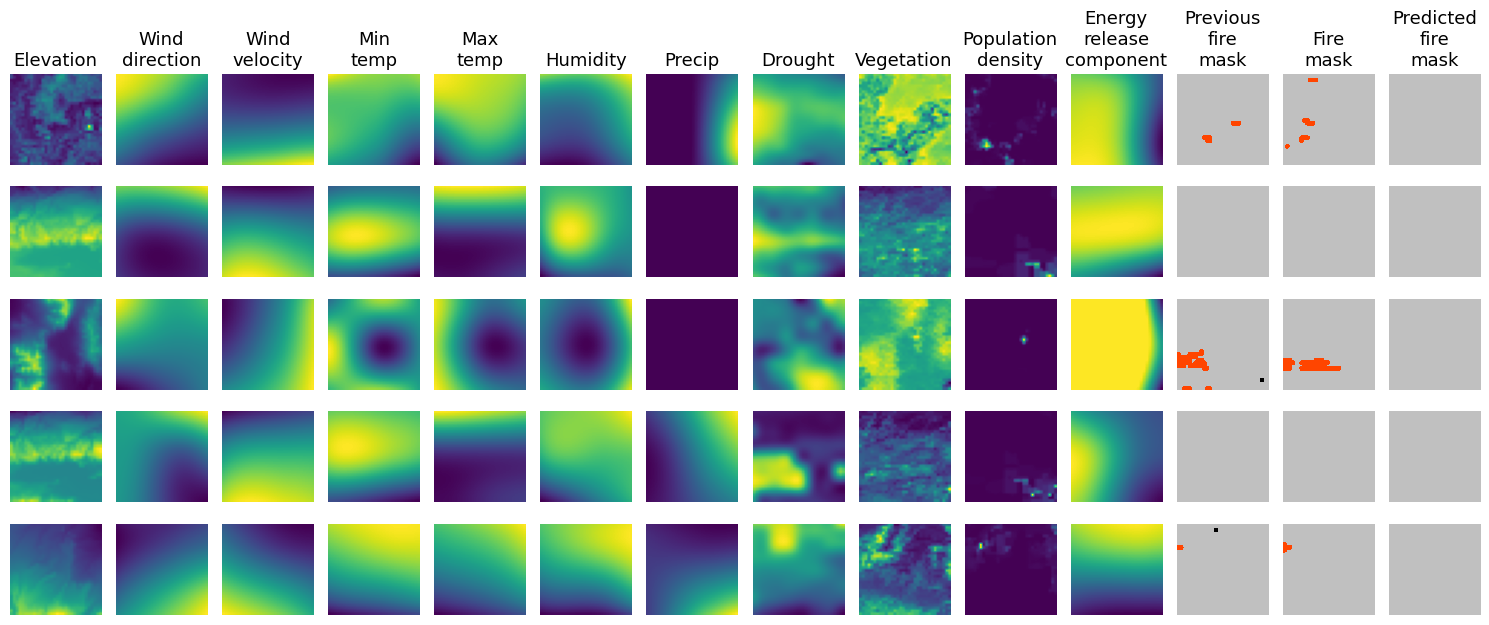

In [28]:
plot_5_predictions(test_loader, model, offset=10)